# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 
# sets the backend of matplotlib to the 'inline' backend:
#With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
#directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

#Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

C:\Users\Sai charan\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:

#Using sqlite3 to retrieve data from sqlite file

con = sqlite3.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
final = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [3]:
final.shape
final['Score'].size

364171

#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
#Taking Sample Data
n_samples = 25000
final = final.sample(n_samples)

###Sorting as we want according to time series
final.sort_values('Time',inplace=True) 
final.head(10)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
270,346140,374449,B00004CI84,A3K3YJWV0N54ZO,Joey,2,3,positive,1001289600,"Beetlejuice is a greatmovie, but they cheated ...",Just to warn you. when in trying to trick you ...,warn tri trick widescreen format compani made ...
1063,443662,479723,B00005U2FA,A3TO9GEQEGKFDC,"N. Smith ""emerald999""",35,35,positive,1020211200,I love this thing,The wine saver is great in so many ways. Obvio...,wine saver great mani way obvious wonder abl o...
306,346053,374357,B00004CI84,A31RM5QU797HPJ,Drez,1,2,positive,1024531200,"&quot;I'm the ghost with the most, babe&quot;",Simply put: Beetlejuice is the funniest comedy...,simpli beetlejuic funniest comedi kind sinc gh...
1065,443667,479728,B00005U2FA,AR5RRP9N2UXDJ,"Boraxo ""Boraxo""",21,23,positive,1029196800,It really works,"I was very skeptical when I bought this item, ...",skeptic bought item imagin amaz discov actual ...
1116,137932,149700,B00006L2ZT,A19JWUIRF6DXLV,Andrew J Monzon,2,4,positive,1036800000,My favorite American Band!,I have been a huge fan of CVB ever since a fri...,huge fan cvb ever sinc friend mine loan casset...
337,346026,374328,B00004CI84,A1SWVKJIQWW33K,Rob Banzai,0,0,positive,1053216000,"Freaky, silly, wry and creative","Ah, Tim Burton before he started taking himsel...",tim burton start take serious michael keaton u...
33,138681,150499,0006641040,A3E7R866M94L0C,"L. Barker ""simienwolf""",2,2,positive,1065830400,Can't explain why,This book has been a favorite of mine since I ...,book favorit mine sinc abl read one first intr...
4835,178085,193108,B0000DJDJR,A3F6UNXVI9LSMA,"Samuel H. Wheeler ""bigdaddysam""",7,7,positive,1066348800,Best Ice Cream Ever!!!,As a kid this ice cream was a favorite treat. ...,kid ice cream favorit treat ive told highest m...
4912,516067,557955,B0000DJDL4,A15SCA1C3F22KW,"Mom2two ""sdbartels2""",0,0,positive,1067990400,Great Holiday tradition,Our family has been giving and recieving Kring...,famili give reciev kringl mani year one danish...


In [5]:
savetofile(final,"sample_25000_knn")

In [6]:
final = openfromfile("sample_25000_knn")

As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [7]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

3
Simply put: Beetlejuice is the funniest comedy of its kind since Ghostbusters.<br />  Michael Keaton plays the title character, a fun-loving ghost that likes to do mischief.  Beetlejuice is called by a couple (Davis and Baldwin) to get rid of the people who live in thier house.


In [8]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"you'd", "that'll", 'have', 'to', 'doing', 'with', 'does', 'you', 'being', 'now', 'itself', 'ain', 'hadn', "it's", 'haven', 'such', 'needn', 'themselves', 'been', 'were', 'that', 'we', 'both', 'why', 'hers', "you'll", 'and', 'same', 'again', "should've", 'm', 'or', 'having', "aren't", 'those', 'then', 'no', 'couldn', 'didn', "haven't", 't', 'd', 'our', 'are', 'did', 'a', 'it', 'ma', "shan't", 'her', 'above', 'she', 'up', 'on', 'own', 'had', 'during', 'can', 'theirs', 'few', 'his', 'where', "won't", 'has', "didn't", 'was', 'ours', 'wouldn', 'here', 'too', 'between', 'whom', 'they', 'against', 'other', 'down', 'below', 'only', 'don', 'how', 'who', "she's", "weren't", 'into', 'for', 'my', 've', 'there', 'more', 'll', 'he', 'is', 'these', 'very', 'y', "isn't", "doesn't", "hasn't", 'of', "couldn't", 'through', 'yours', 'by', "mightn't", 'in', 'your', 'from', 'once', "needn't", 'mustn', 'won', 'myself', 'do', 'weren', 'any', 'just', "hadn't", 'this', 'than', 'yourself', 'isn', 'doesn', "you

In [9]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

# [7.2.2] Bag of Words (BoW)

In [10]:
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (25000, 20028)
the number of unique words  20028


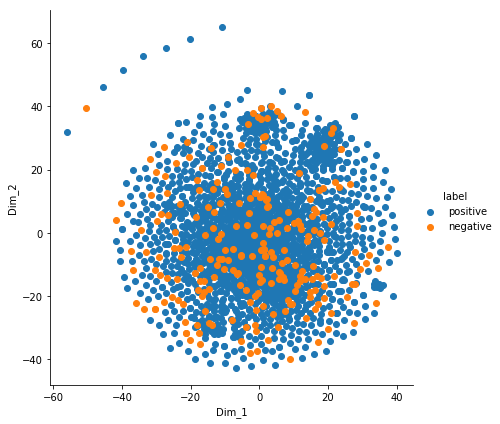

In [13]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 2000 points as TSNE takes a lot of time for 364K points
data_2000 = final_counts[0:2000,:].todense()
labels_2000 = final["Score"][0:2000]

model = TSNE(n_components=2, random_state=0,perplexity = 20,n_iter=500,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

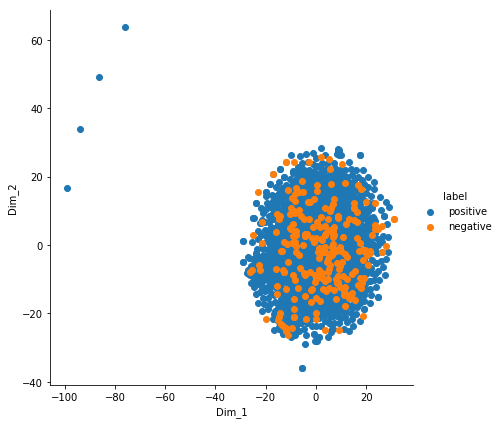

In [11]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 2000 points as TSNE takes a lot of time for 364K points
data_2000 = final_counts[0:2000,:].todense()
labels_2000 = final["Score"][0:2000]

model = TSNE(n_components=2, random_state=0,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

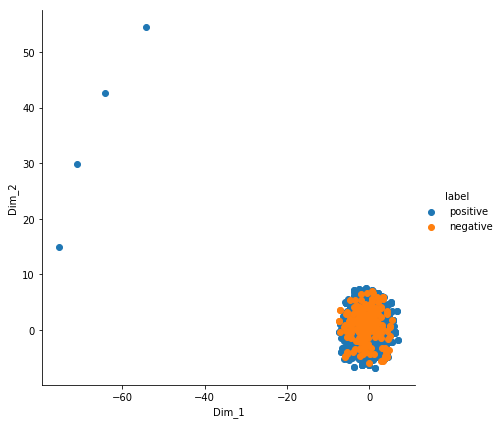

In [12]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 2000 points as TSNE takes a lot of time for 364K points
data_2000 = final_counts[0:2000,:].todense()
labels_2000 = final["Score"][0:2000]

model = TSNE(n_components=2, random_state=0,perplexity = 40,n_iter=2000,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

# [7.2.5] TF-IDF

In [14]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (25000, 20028)
the number of unique words including both unigrams and bigrams  20028


In [15]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[1000:1010])

some sample features(unique words in the corpus) ['asset', 'assign', 'assimil', 'assist', 'assit', 'assoc', 'associ', 'assort', 'asst', 'assuag']


In [16]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

top_tfidf

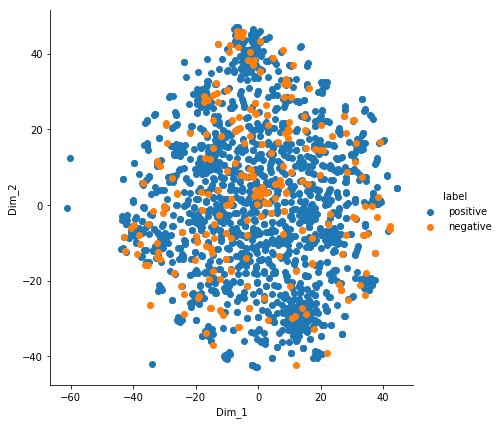

In [19]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 2000 points as TSNE takes a lot of time for 364K points
data_2000 = final_tf_idf[0:2000,:].todense()
labels_2000 = final["Score"][0:2000]
model = TSNE(n_components=2, random_state=0,perplexity = 20,n_iter=500,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = model.fit_transform(data_2000)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

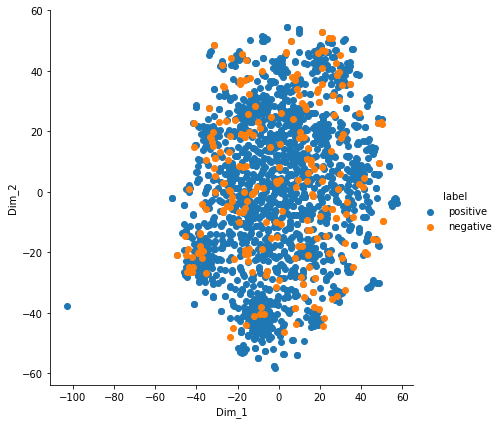

In [17]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 2000 points as TSNE takes a lot of time for 364K points
data_2000 = final_tf_idf[0:2000,:].todense()
labels_2000 = final["Score"][0:2000]
model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = model.fit_transform(data_2000)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

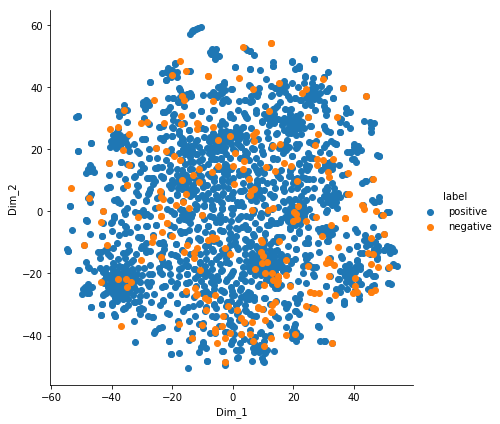

In [18]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 2000 points as TSNE takes a lot of time for 364K points
data_2000 = final_tf_idf[0:2000,:].todense()
labels_2000 = final["Score"][0:2000]
model = TSNE(n_components=2, random_state=0,perplexity = 40,n_iter=2000,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = model.fit_transform(data_2000)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

# [7.2.6] Word2Vec

In [20]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [21]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

beetlejuic well written movi everyth excel act special effect delight chose view movi
*****************************************************************
['beetlejuic', 'well', 'written', 'movi', 'everyth', 'excel', 'act', 'special', 'effect', 'delight', 'chose', 'view', 'movi']


In [22]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [23]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  6936
sample words  ['beetlejuic', 'well', 'written', 'movi', 'everyth', 'excel', 'act', 'special', 'effect', 'delight', 'chose', 'view', 'warn', 'tri', 'trick', 'format', 'compani', 'made', 'mistak', 'also', 'includ', 'full', 'screen', 'version', 'compar', 'seem', 'pictur', 'top', 'bottom', 'must', 'mean', 'take', 'cut', 'slight', 'call', 'strang', 'would', 'expect', 'easier', 'make', 'care', 'edit', 'rip', 'mani', 'peopl', 'wine', 'saver', 'great', 'way', 'obvious']


In [24]:
w2v_model.wv.most_similar('tasti')

[('delici', 0.8249207735061646),
 ('yummi', 0.8163653612136841),
 ('satisfi', 0.7746168971061707),
 ('chewi', 0.748699426651001),
 ('crisp', 0.7411867380142212),
 ('crunchi', 0.7308413982391357),
 ('combin', 0.7256790995597839),
 ('dens', 0.7130439877510071),
 ('hearti', 0.7090280652046204),
 ('nutriti', 0.701934814453125)]

In [25]:
w2v_model.wv.most_similar('like')

[('prefer', 0.7224119305610657),
 ('aw', 0.6665008664131165),
 ('bland', 0.6328355073928833),
 ('remind', 0.6285274028778076),
 ('think', 0.6223689317703247),
 ('terribl', 0.613071858882904),
 ('nasti', 0.6097637414932251),
 ('good', 0.6071714162826538),
 ('appeal', 0.6024086475372314),
 ('funki', 0.6020952463150024)]

# [7.2.7] Avg W2V, TFIDF-W2V

In [26]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 25000/25000 [01:35<00:00, 260.91it/s]


25000
50


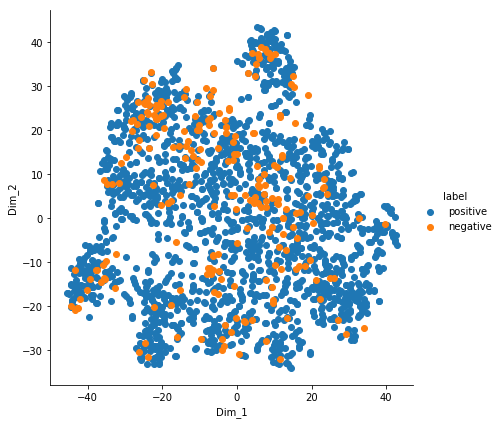

In [29]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 1000 points as TSNE takes a lot of time for 364K points
data_2000 = sent_vectors[0:2000]
labels_2000 = final["Score"][0:2000]

TSNE_model = TSNE(n_components=2, random_state=0,perplexity = 20,n_iter=500,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

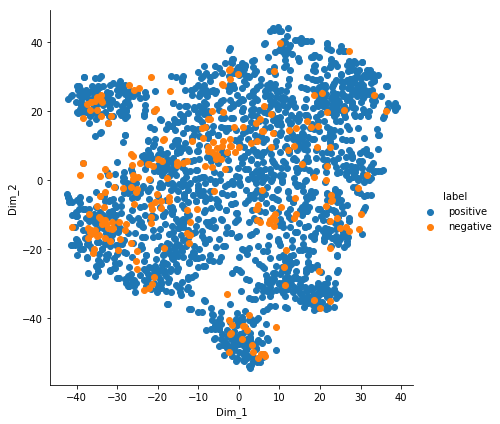

In [27]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 1000 points as TSNE takes a lot of time for 364K points
data_2000 = sent_vectors[0:2000]
labels_2000 = final["Score"][0:2000]

TSNE_model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

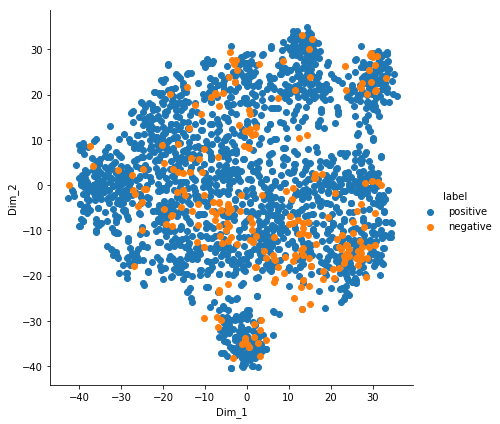

In [28]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 1000 points as TSNE takes a lot of time for 364K points
data_2000 = sent_vectors[0:2000]
labels_2000 = final["Score"][0:2000]

TSNE_model = TSNE(n_components=2, random_state=0,perplexity = 40,n_iter=2000,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

In [30]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [31]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 25000/25000 [01:45<00:00, 238.09it/s]


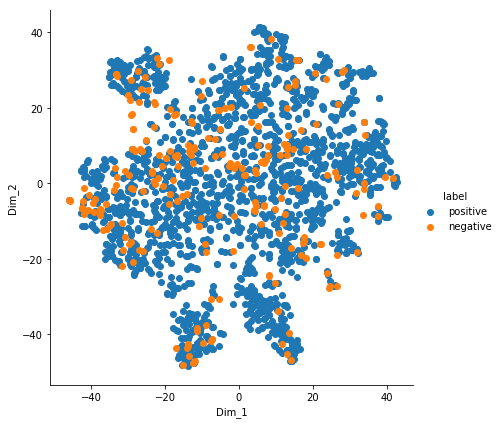

In [34]:

# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 1000 points as TSNE takes a lot of time for 364K points
data_1000 = tfidf_sent_vectors[0:2000]
labels_1000 = final["Score"][0:2000]

TSNE_model = TSNE(n_components=2, random_state=0,perplexity = 20,n_iter=500,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

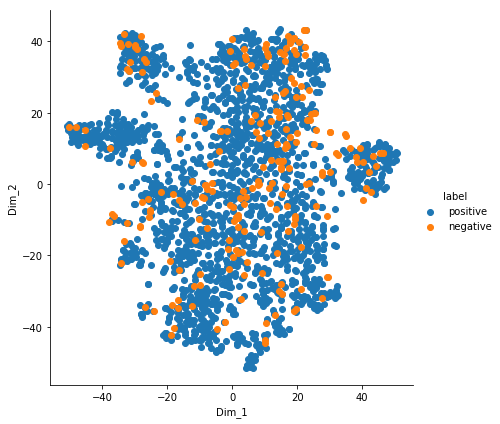

In [32]:

# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 1000 points as TSNE takes a lot of time for 364K points
data_1000 = tfidf_sent_vectors[0:2000]
labels_1000 = final["Score"][0:2000]

TSNE_model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

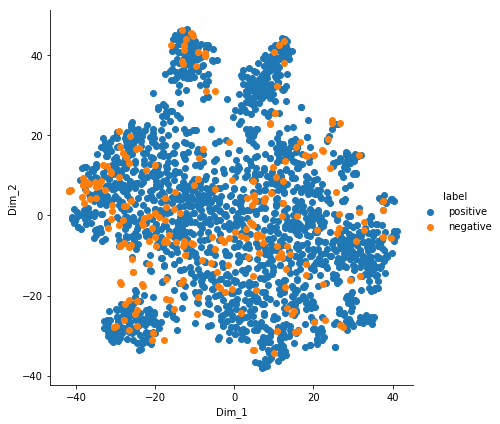

In [33]:

# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 1000 points as TSNE takes a lot of time for 364K points
data_1000 = tfidf_sent_vectors[0:2000]
labels_1000 = final["Score"][0:2000]

TSNE_model = TSNE(n_components=2, random_state=0,perplexity = 40,n_iter=2000,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

# Observations

## tsne plot analysis

1.Bow:by observing above plots we conclude that as the perplexity and number of iterations increases positive and negative classes are overlapping and they are unreadable.
2.Tf-Idf:observing above plots we conclude that as the perplexity and number of iterations increases the overlapping of both the classes  increases and also the density of classes around the plot tend to decrease and then Increased in later increase of perplexity and iterations.
3.Avg W2v:observing above plots we conclude that as the perplexity and number of iterations increases  the area of covered by the classes on the plot decreased.
4.Tf-idf W2v:observing above plots we conclude that as the perplexity and number of iterations increases    the overlapping of both the classes alsp increases